# Using Craigslist to compare prices in the Bay Area

In the [last post](http://chrisholdgraf.com/querying-craigslist-with-python/) I showed how to use a simple python bot to scrape data from Criagslist. This is a quick follow-up to take a peek at the data.

> Note - data that you scrape from Craigslist is pretty limited. They tend to clear out old posts, and you can only scrape from recent posts anyway to avoid them blocking you. 

Now that we've got some craigslist data, what questions can we ask? Well, a good start would be to see where we want (or don't want) to rent our house. Let's compare the housing market in a few different regions of the Bay Area.

In [ ]:
# Seaborn can help create some pretty plots
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
%matplotlib inline
sns.set_palette('colorblind')
sns.set_style('white')

In [ ]:
# First we'll load the data we pulled from before
results = pd.read_csv('../data/craigslist_results.csv')

# Price distributions
As a start, let's take a look at the distribution of home prices to get an idea for what we're dealing with:

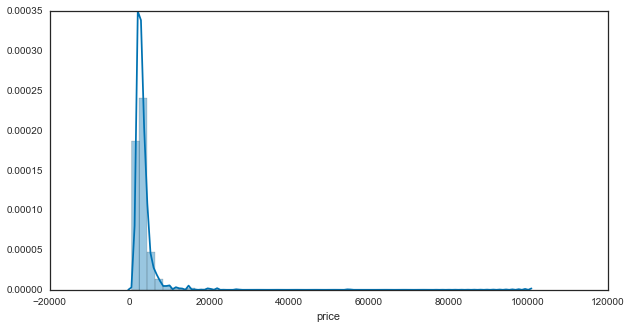

In [ ]:
f, ax = plt.subplots(figsize=(10, 5))
sns.distplot(results['price'].dropna())

That's not super useful - it looks like we have a highly skewed distribution with a few instances way out to the right. We'll convert to a log scale from here on to make it easier to comprehend:

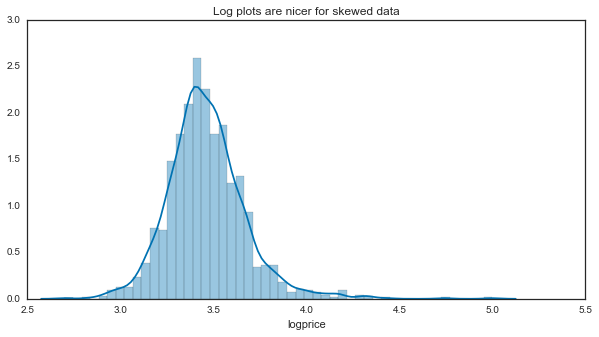

In [ ]:
f, ax = plt.subplots(figsize=(10, 5))
results['logprice'] = results['price'].apply(np.log10)
sns.distplot(results['logprice'].dropna())
ax.set(title="Log plots are nicer for skewed data")

In [ ]:
# Don't forget the log mappings:
print(['10**{0} = {1}'.format(i, 10**i) for i in ax.get_xlim()])

However, what we really want is to look at the breakdown of prices for a few locations in the bay area. Luckily Craigslist stores this in the URL of our search, so we can easily split this up with a pandas `groupby`:

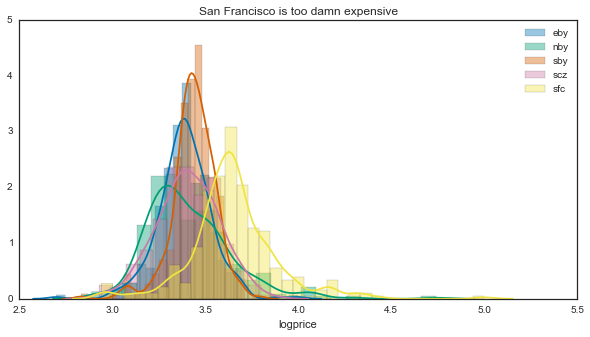

In [ ]:
f, ax_hist = plt.subplots(figsize=(10, 5))
for loc, vals in results.groupby('loc'):
    sns.distplot(vals['logprice'].dropna(), label=loc, ax=ax_hist)
    ax_hist.legend()
    ax_hist.set(title='San Francisco is too damn expensive')

In [ ]:
summary = results.groupby('loc').describe()['logprice'].unstack('loc')
for loc, vals in summary.iteritems():
    print('{0}: {1}+/-{2}'.format(loc, vals['mean'], vals['std']/vals.shape[0]))
    
print('Differences on the order of: $' + str(10**3.65 - 10**3.4))

That's a bit unsurprising - San Francisco is significantly more expensive than any other region in the area. Note that this is a log scale, so small differences at this scale == large differences in the raw values.

However, it looks like the shapes of these prices are different as well. If any of these distributions aren't symmetric around the center, then describing it with the mean +/- standard deviation isn't so great.

Perhaps a better way to get an idea for what kind of deal we're getting is to directly calculate price per square foot. Let's see how this scales as the houses go up.

In [ ]:
# We'll quickly create a new variable to use here
results['ppsf'] = results['price'] / results['size']

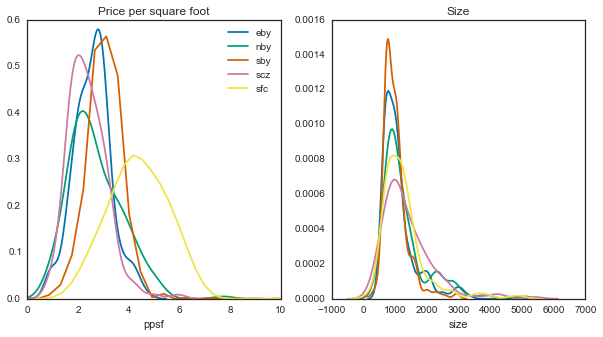

In [ ]:
# These switches will turn on/off the KDE vs. histogram
kws_dist = dict(kde=True, hist=False)
n_loc = results['loc'].unique().shape[0]
f, (ax_ppsf, ax_sze) = plt.subplots(1, 2, figsize=(10, 5))
for loc, vals in results.groupby('loc'):
    sns.distplot(vals['ppsf'].dropna(), ax=ax_ppsf,
                 bins=np.arange(0, 10, .5), label=loc, **kws_dist)
    sns.distplot(vals['size'].dropna(), ax=ax_sze,
                 bins=np.arange(0, 4000, 100), **kws_dist)
ax_ppsf.set(xlim=[0, 10], title='Price per square foot')
ax_sze.set(title='Size')

So it looks like size-wise, there aren't many differences here. However, with price per square foot, you'll be paying a lot more for the same space in SF.

Finally, let's take a look at how the price scales with the size. For this, we'll use a `regplot` to fit a line to each distribution.

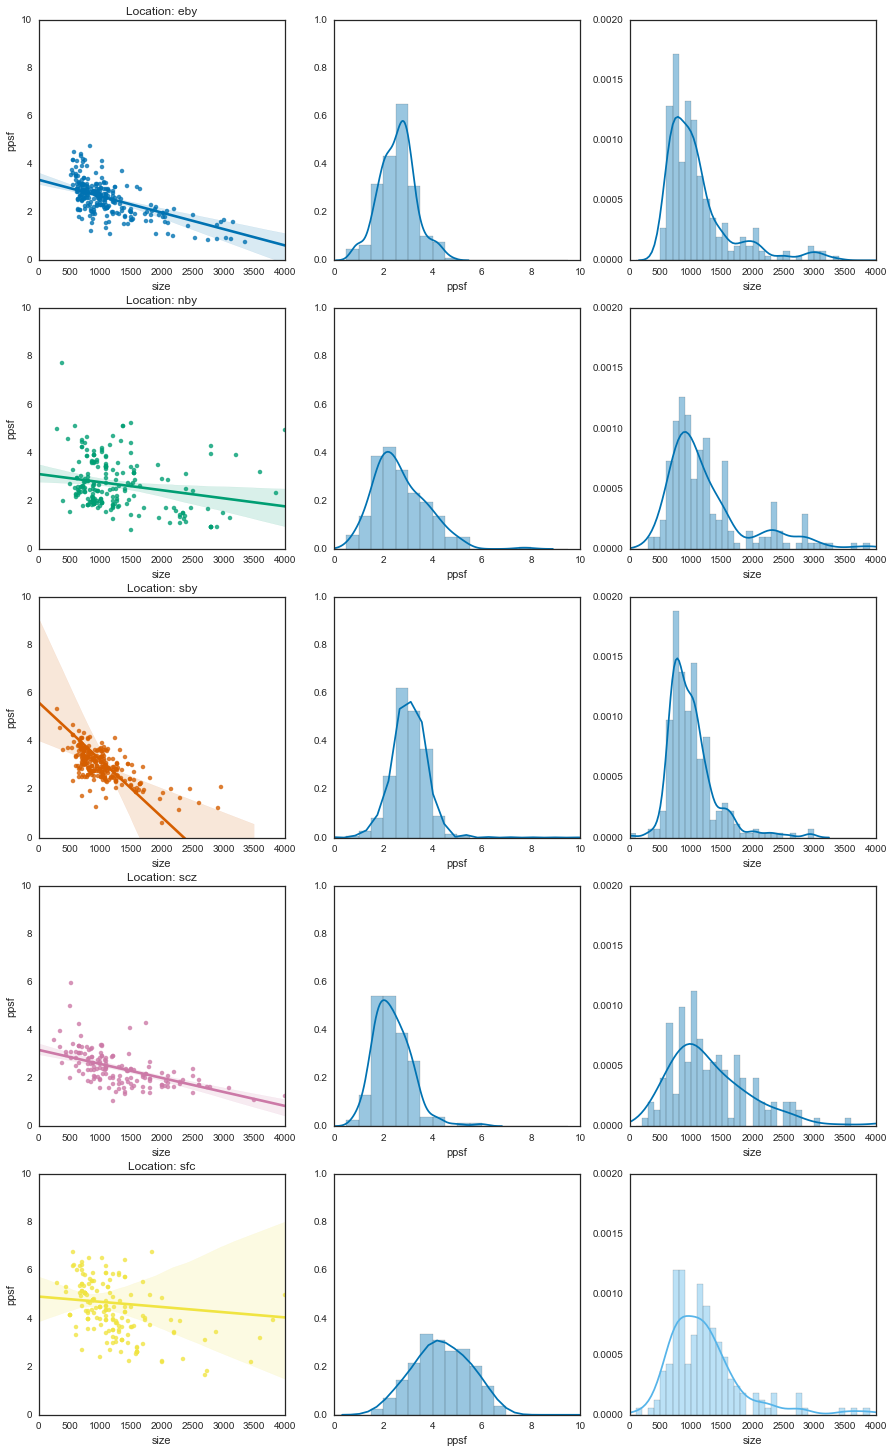

In [ ]:
# Split up by location, then plot summaries of the data for each
n_loc = results['loc'].unique().shape[0]
f, axs = plt.subplots(n_loc, 3, figsize=(15, 5*n_loc))
for (loc, vals), (axr) in zip(results.groupby('loc'), axs):
    sns.regplot('size', 'ppsf', data=vals, order=1, ax=axr[0])
    sns.distplot(vals['ppsf'].dropna(), kde=True, ax=axr[1],
                 bins=np.arange(0, 10, .5))
    sns.distplot(vals['size'].dropna(), kde=True, ax=axr[2],
                 bins=np.arange(0, 4000, 100))
    axr[0].set_title('Location: {0}'.format(loc))

_ = plt.setp(axs[:, 0], xlim=[0, 4000], ylim=[0, 10])
_ = plt.setp(axs[:, 1], xlim=[0, 10], ylim=[0, 1])
_ = plt.setp(axs[:, 2], xlim=[0, 4000], ylim=[0, .002])

And now on top of one another

(0, 10)

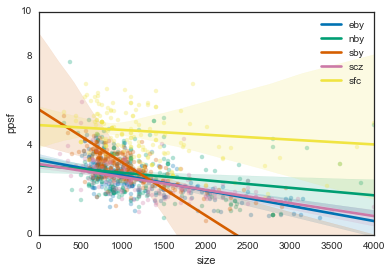

In [ ]:
f, ax = plt.subplots()
locs = [res[0] for res in results.groupby('loc')]
for loc, vals in results.groupby('loc'):
    sns.regplot('size', 'ppsf', data=vals, order=1, ax=ax,
                scatter=True, label=loc, scatter_kws={'alpha':.3})

# If we want to turn off the scatterplot
scats = [isct for isct in ax.collections
         if isinstance(isct, mpl.collections.PathCollection)]
# plt.setp(scats, visible=False)

ax.legend(locs)
ax.set_xlim([0, 4000])
ax.set_ylim([0, 10])

Basically, lines that go down more steeply mean you get a better deal the bigger the place is.

For instance, if you're in the southbay you might be paying \$6/sqf for a 600 sq. ft. place, but $1/sqf for a 2000 sq. ft. place. On the other hand, San Francisco is pretty consistent, with a relatively flat line. This means that you'll be paying pretty much the same per square foot regardless of how big your place is. In fact, all of the other regions seem to follow the same trend - so if you're looking for more efficient big-place finds, go with the South Bay.

Also note that this gives us information about the uncertainty in these estimates. The error bars are so wide for San Francisco because we don't have many data points at high values (because there aren't that many places >2000 square feet in SF). It's anyone's guess as to what this would cost.

# Text analysis
Finally, we can also learn a bit from the text in the post titles. We could probably get better information by using the post text itself, but this would require some extra legwork looking up the URL of each entry and pulling the body of text from this. We'll stick with titles for now.

To do this, we'll use some text analysis tools in `scikit-learn`. This is good enough for our purposes, though if we wanted to do something fancier we could use something like `gensim`, `word2vec`, or `nltk`. (we'd also probably need a lot more data).

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
import string

First we'll do some quick data cleaning - we'll only keep datapoints with a title, and then define some characters to remove so that the definition of "a word" makes more sense.

In [ ]:
word_data = results.dropna(subset=['title'])

# Remove special characters
rem = string.digits + '/\-+.'
rem_chars = lambda a: ''.join([i for i in a if i not in rem])
word_data['title'] = word_data['title'].apply(rem_chars)

Next, we'll remove words that are too specific (from a geographical standpoint) to the regions we're using. Otherwise you'll just get a bunch of clusters with streetnames etc. predicting the Bay Area region.

In [ ]:
loc_words = {'eby': ['antioch', 'berkeley', 'dublin', 'fremont', 'rockridge',
                     'livermore', 'mercer', 'ramon'],
             'nby': ['sausalito', 'marin', 'larkspur', 'novato', 'petaluma', 'bennett', 
                     'tiburon', 'sonoma', 'anselmo', 'healdsburg', 'rafael'],
             'sby': ['campbell', 'clara', 'cupertino', 'jose'],
             'scz': ['aptos', 'capitola', 'cruz', 'felton', 'scotts',
                     'seabright', 'soquel', 'westside', 'ucsc'],
             'sfc': ['miraloma', 'soma', 'usf', 'ashbury', 'marina',
                     'mission', 'noe']}

# We can append these to sklearn's collection of english "stop" words
rand_words = ['th', 'xs', 'x', 'bd', 'ok', 'bdr']
stop_words = [i for j in loc_words.values() for i in j] + rand_words
stop_words = ENGLISH_STOP_WORDS.union(stop_words)

Finally, we will vectorize this data so that it can be used with sklearn algorithms. This takes a list of "bags" of words, and turns it into a list of vectors, where the length of each vector is the total number of words we've got. Each position of the vector corresponds to 1 word. It will be "1" if that word is present in the current item, and 0 otherwise:

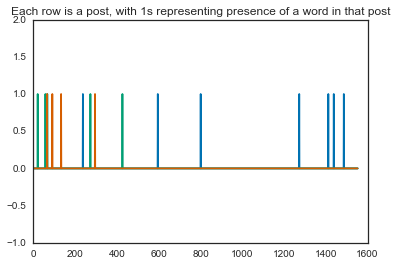

In [ ]:
vec = CountVectorizer(max_df=.6, stop_words=stop_words)
vec_tar = LabelEncoder()

counts = vec.fit_transform(word_data['title'])
targets = vec_tar.fit_transform(word_data['loc'])
plt.plot(counts[:3].toarray().T)
plt.ylim([-1, 2])
plt.title('Each row is a post, with 1s representing presence of a word in that post')

Let's do a quick description of the most common words in each region. We can use our vectorized vocabulary and see which words were most common.

In [ ]:
top_words = {}
for itrg in np.unique(targets):
    loc = vec_tar.classes_[itrg]
    # Pull only the data points assigned to the current loction
    icounts = counts[targets == itrg, :].sum(0).squeeze()
    
    # Which counts had at least five occurrences
    msk_top_words = icounts > 5
    
    # The inverse transform turns the vectors back into actual words
    top_words[loc] = vec.inverse_transform(msk_top_words)[0]

Then, we'll print the words that are unique to each area by filtering out ones that are common across locations:

In [ ]:
unique_words = {}
for loc, words in top_words.iteritems():
    others = top_words.copy()
    others.pop(loc)
    unique_words[loc] = [wrd for wrd in top_words[loc]
                         if wrd not in np.hstack(others.values())]
for loc, words in unique_words.iteritems():
    print('{0}: {1}\n\n---\n'.format(loc, words))

Apparently people in the North Bay like appliances, people in Santa Cruz like the beach, people in the East Bay need the Bart, and people in San Francisco have victorians...who knew.

Just for fun we'll also do a quick classification algorithm to see if some machine learning can find structure in these words that separates one location from another:

In [ ]:
mod = LinearSVC(C=.1)
cv = StratifiedShuffleSplit(targets, n_iter=10, test_size=.2)

coefs = []
for tr, tt in cv:
    mod.fit(counts[tr], targets[tr])
    coefs.append(mod.coef_)
    print(mod.score(counts[tt], targets[tt]))
coefs = np.array(coefs).mean(0)

Doesn't look like it (those are horrible generalization scores), but we'll look at what coefficients it considered important anyway:

In [ ]:
for loc, icoef in zip(vec_tar.classes_, coefs):
    cut = np.percentile(icoef, 99)
    important = icoef > cut
    print('{0}: {1}'.format(loc, vec.inverse_transform(important)))

You may note that these are quite similar to the words that were unique to each location as noted above - such is the power of machine learning :)

## So what have we learned?
Well, you might say that we've merely quantified what everybody already knows: San Francisco is expensive, really expensive. If you're looking for a place in the Bay Area, you can expect to shell out a lot more for the same square footage.

However, what's also interesting is that apartments in the Bay Area don't seem to obey the same rules that other regions do - they don't necessarily become more economically efficient as the place gets bigger. This is in stark contrast to the south bay, where places are pretty expensive in general, but in ways that you'd expect for an apartment.

Finally, there are probably lots of other cool things that you could do with these datasets, especially if you wanted to break things down by neighborhood and collect more data.